# Welcome to Inscopy
This notebook should guide you to the most common functions. You will.

1. Load data using the functions load_cells and load_TTL.
2. Inspect data using the function plot_cells.
3. Contruct peri-event data using the function peri_event.
4. Normalize the peri-event data using any of the provided normalization methods.
5. Plot (sorted) peri-event data using the function plot_PE.


  

In [1]:
# Here we import the libaries that we'll use.
import inscopy.main as inx # The main Inscopy library
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Loading the data
In order to run this example notebook, two example datafiles have been included. The are:

    - Mouse3_AC1_test.csv (containing all the identified cells of one recording)   
    - Mouse3_AC1_TTL.csv (Containing the TTL pulses in that same recording)
    
The files are obtained during a simple conditioning task in which a CS+ predicts a stimulus and a CS- is without scheduled concequences. The CS+, CS- and stimulus all have a duration of 2sec.


In [2]:
# Two load data functions are included in Inscopy, one for data and one for TTL pulses
cells = inx.load_cells('example_data/Mouse3_AC1_test.csv')
TTL = inx.load_TTL('example_data/Mouse3_AC1_TTL_test.csv')


Let's have a look at how the data is organized. The cells are stored in a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html). Every column contains a cell, the index contains a timeline.

In [3]:
# Print the head of the dataframe
cells.head()

,C014,C015,C019,C025,C026,C027,C032,C034,C036,C037,...,C072,C074,C075,C076,C077,C082,C087,C088,C090,C098
,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted,...,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted
0.000000,221.23030,419.1952,231.8218,742.5095,1353.8890,227.8089,43.416420,-325.8921,422.5137,-276.3569,...,262.73330,501.2041,-0.590720,232.5705,716.9009,795.0726,581.6196,88.45294,-7.050067,146.8416
0.049961,125.99520,336.5704,254.4867,525.0764,1304.1980,254.7474,159.273000,-147.1034,145.5259,-68.4526,...,63.22830,612.5137,155.886000,315.2365,796.4816,489.1010,578.2794,195.21210,-31.871020,159.7640
0.099922,115.22560,329.6065,102.1143,798.1436,970.5417,130.3991,72.904040,-143.3747,284.4962,-269.1349,...,285.99220,599.7084,6.539417,309.6529,708.6279,497.0079,491.3867,25.77842,147.278700,197.9656
0.149883,-52.70831,398.1596,221.1164,370.0634,942.3802,281.1639,-64.085540,-342.6367,287.6556,-106.3225,...,66.54649,359.8383,152.757800,378.4610,421.2542,643.1846,470.8666,-32.66871,84.086980,201.4958
0.199844,34.40885,450.8571,227.3858,796.7164,993.2611,139.7210,9.392694,-286.8622,226.6733,-320.9226,...,339.38660,323.0055,347.798700,187.4776,653.2042,282.1373,337.4106,-37.89618,102.271700,291.7189


The TLL timestamps meanwhile are stored in a Python dict. The keys of the dict are the TLL channels on the nVista system. The values are again DataFrames, but in this case every row is a pulse on the channel.

In [4]:
# Look at the available keys
print('The available channels are:')
[print('   - ' +i) for i in TTL.keys()]

# Look at one in particular
print('\nThis is for instance what GPIO-1 looks like in this datafile:')
TTL['GPIO-1'].head()

The available channels are:
   - GPIO-1
   - GPIO-2
   - GPIO-3
   - GPIO-4
   - EX-LED
   - e-focus
   - BNC Sync Output

This is for instance what GPIO-1 looks like in this datafile:


,Start,Stop,Duration
0,88.8342,90.8358,2.0016
1,124.7032,126.7050,2.0018
2,183.0524,185.0542,2.0018
3,210.5018,212.5028,2.0010
4,298.5552,300.5560,2.0008


# First look at the data
In the experiment from the example data, the stimulus is indicated by the pulses on channel GPIO-1, while the CS+ is indicated by the <i>offset</i> of a 1sec pulse on channel GPIO-2 and the CS- by the <i>offset</i> of a 0.5sec pulse on channel GPIO-2. Below we take a first look at the data. We use the function "plot_cells" to plot two cells as well as the stimulus on GPIO-1.

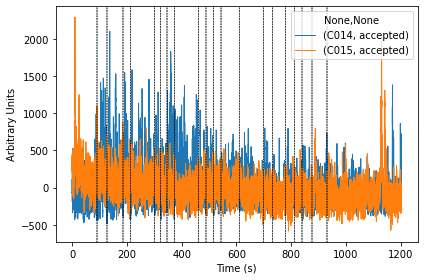

In [5]:
# Let's look at the first two cells. Here we use 'iloc' to index the first two columns, but using the column
# names of the first two cells (e.g. [['C014', 'C015']]) would also work.
first_two_cells = cells.iloc[:, :2]
stimulus = TTL['GPIO-1']

# We use the function 'plot_cells' to plot the data
inx.plot_cells(first_two_cells, stimulus)


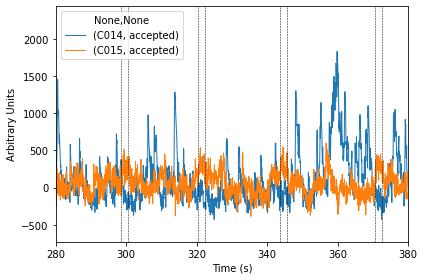

In [6]:
# Higher time resolution of a series of 3 stimuli:
inx.plot_cells(first_two_cells, stimulus, window=[280, 380])



Interestingly, from looking at this raw data, you can alreay tell that cell C014 and cell C015 respond oppositely to the stimulus.

# Making peri-event histograms
A very straightforward way of exploring the data is by plotting peri-event histograms. Here we will build peri-event histograms of the activity of all the cells in the DataFrame 'cells' around the stimulus timestamps that we collected on channel GPIO-1.

The build-in function 'peri_event' will produce peri-event plots for one or multiple cells. If the input is a Dataframe with data from multiple cells (e.g. multiple columns) the output is a dictonary with the cell names as keys. If only one cell (one column) is passed to peri_event, the output is a Dataframe. For every cell the output is a DataFrame with a timeline in the index and the individual trials as columns.

The second argument of peri_event are the 'stamps', which will be T=0 in our peri-event data. In this case it is the stimulus onset.


In [7]:
# We're going to look at the stimulus onset (e.g. the 'start')
stamps = TTL['GPIO-1'].Start

# Grab PE_data
PE_data = inx.peri_event(cells, stamps, window=10) 

# The output is a dictionary with all the cells as keys. Let's have a look at the first cell:
PE_data['C014'].head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-10.00,84.867820,293.8329,59.28467,271.9401,274.055800,-194.67630,-118.418000,1016.1620,514.1473,-217.02950,-75.439580,-104.4755,36.81921,-298.6285,-207.70700,-18.628530,-27.06467,50.40192,-66.090490,-254.0691
-9.95,101.527900,279.9279,-30.33431,191.9528,310.782000,-280.07850,-74.365680,1000.0520,580.6703,-196.63220,0.658461,-121.8734,-93.29137,-102.0664,-127.90710,-74.395150,-45.01199,-58.75743,-187.319000,-156.3191
-9.90,5.697567,216.1025,-61.91505,272.8240,177.299800,-253.18890,2.327093,929.0688,618.9327,-100.07000,-166.432100,-114.5904,49.10563,-220.5701,-147.18240,-3.136431,-38.13815,-255.26640,-167.882400,-199.0899
-9.85,20.775010,261.5420,-152.73540,154.8592,-4.031449,-39.38573,15.611290,803.3035,653.1757,12.90992,-152.894800,-123.0150,63.10105,-164.9971,-205.47950,23.805320,-144.66730,-90.82121,4.659212,-87.0826
-9.80,85.351910,225.5889,-150.71610,136.3820,57.981070,-250.42760,-34.927170,718.7255,507.5587,-111.39110,-106.291700,-232.1729,53.18783,-169.7326,-75.94897,-226.007100,-173.32910,-174.34060,86.320910,-185.3730


As you can see the output is a Dataframe. The index is a timeline (T=0 is the stamp) and the columns are the individual trials. In this case the stimulus was presented 20 times, so the peri-event data has 20 columns. We'll plot the peri-event data below, but first we have to talk about normalization.

Inscopy has 4 build-in ways to normalize peri-event data. Z-score, baseline-subtraction and auROC are based on a baseline (by default all the datapoints in the peri-event data before T=0), while min-max is not.

### Z-score
Z-score normalization is probably the best method if you want to look at one individual cell or if you want to combine multiple cells in one dataset, but you don't have enough trials per cell to do auROC. A Z-score of '1' is the standard deviation of the baseline, thus the signal value is dependend on how much variation you have in your baseline. In addition, the mean value of the baseline is subtracted, to the baseline ends op at 0 by default.

### min-max
Min-max normalization simply rescales all the data to fit in the interval 0:1. If you want to fit the data to a different interval, simply multiply by the desired interval width and add the floor of the desired interval (e.g. multiply by 2 and subtract 1 to scale between -1 and 1).

### baseline subtraction
Baseline subtraction does not really normalize the data but it does subtract the baseline so any values are relative increases or discreases.

### auROC
The area under the receiver opperant characteristic is a measure for how much information can be gained from any particular data point. It automatically scales the data to values between 0 and 1, with the baseline at 0.5. A value of '1' at T=x means that a threshold exists which perfectly sepparates all datapoints at T=x from the baseline. A value of 0 means the same, but in this case, the values are lower than the baseline. An important difference between auROC and the other methods is that it takes all the trials into consideration to produce a single 1-D vector for each cell. This vector is not very sensitive to outliers or low baseline (such as Z-score normalization) and the values truly say something about how much information can be gained from the cell activity at any given time point. If enough trials are available it is most likely the best normalization method. For more information see [Cohen et al. Nature 2012](https://www.nature.com/articles/nature10754), especially supplementary figure S1.


In [8]:
# Since we want to plot a heatmap of an individual cell (as an example) we'll use z-score for now.
PE_data_normalized = inx.normalize_PE(PE_data, method='z-score')

# The output is again a dictionary with all the cells as keys. Let's have a look at the second cell:
PE_data_normalized['C015'].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-10.00,0.771163,1.936149,1.313325,-0.052368,0.322961,0.620437,0.786508,0.371174,-1.003603,-1.110123,-1.021221,0.500589,0.824658,1.244971,0.897327,-2.720718,-1.859990,-2.302984,0.444653,1.104464
-9.95,-0.144311,1.908412,0.556298,0.055644,0.066757,1.552184,-0.329418,0.106144,-2.662991,-1.869569,1.553493,0.387316,0.819922,1.482951,-0.002714,-0.849482,-0.877800,-1.047757,0.020356,0.058300
-9.90,-0.815696,2.852071,2.316653,1.115077,-0.341677,1.471056,-0.953015,0.738594,-1.162282,-1.939332,-0.964843,-0.662871,1.078405,1.282745,-0.038466,-0.630930,-0.465416,-1.594740,1.465712,1.263630
-9.85,-0.887758,3.079178,1.206095,0.774487,-0.173151,1.040351,-0.768191,-0.132581,-0.021767,-1.636759,-0.481336,0.247137,-0.609582,2.395396,1.221782,0.126659,-0.760784,-1.881297,2.014797,-0.808632
-9.80,-1.183612,2.752495,1.360424,1.352600,-0.179043,0.753672,0.942660,0.543633,-1.390298,-1.497097,0.977807,1.183666,0.922156,1.489536,0.963127,-0.748226,-1.039381,-1.463393,1.228322,1.108474


Finally, to plot the data, we use the function plot_PE. Note that this function takes a single DataFrame as input (so you can't feed it the entire dict). Bellow we plot the second cell (cell C015). The second argument for the plot is the colormap for the heatmap. See an overview of all possible colormaps [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

Note that plot_PE returns the figure and axes handles, which can be used to format the figure to your liking if you run this code from a terminal or an IDE such as Spyder or Pycharm.

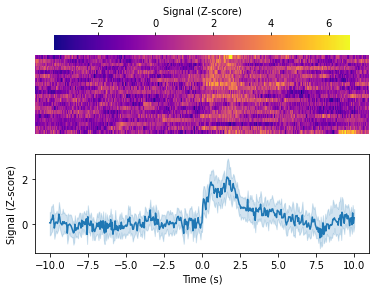

(<Figure size 432x288 with 3 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:xlabel='Time (s)', ylabel='Signal (Z-score)'>],
       dtype=object))

In [9]:
# Plot the peri-event data
inx.plot_PE(PE_data_normalized['C015'], cmap='plasma')

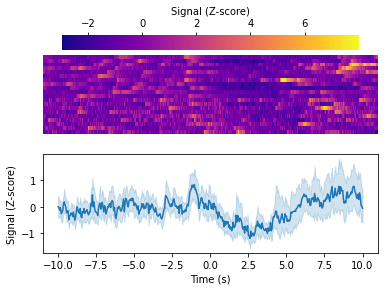

(<Figure size 432x288 with 3 Axes>,
 array([<AxesSubplot:>,
        <AxesSubplot:xlabel='Time (s)', ylabel='Signal (Z-score)'>],
       dtype=object))

In [10]:
# Interestingly, the same example dataset also has cells that are inhibited by the stimulus:
inx.plot_PE(PE_data_normalized['C014'], cmap='plasma')

# Combining multiple cells
The function plot_PE will plot one DataFrame. It does not care wether or not the columns are individual trials or average responses of individual cells. So you can either average the responses for every cell individually and combine them into one DataFrame, or use the build-in function multi_cell_pe.

Note that the normalization method we use here (auROC) might take a few minutes.


In [11]:
# Grab the data
combined_data = inx.multi_cell_PE(cells, stamps=TTL['GPIO-1'].Start, norm_method='auroc')

# Let's have a look at the data
combined_data.head()

,C014,C015,C019,C025,C026,C027,C032,C034,C036,C037,...,C072,C074,C075,C076,C077,C082,C087,C088,C090,C098
,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted,...,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted,accepted
-10.00,0.501075,0.526413,0.563087,0.542519,0.506738,0.546663,0.509350,0.567837,0.496050,0.404569,...,0.524275,0.513469,0.432156,0.317831,0.490638,0.482025,0.403881,0.573500,0.473294,0.464287
-9.95,0.486975,0.503213,0.433812,0.537713,0.478744,0.551525,0.476912,0.544137,0.565525,0.391269,...,0.542481,0.528356,0.457881,0.372000,0.486538,0.487894,0.431725,0.555200,0.411300,0.462688
-9.90,0.464044,0.494169,0.571588,0.564106,0.557169,0.514756,0.465700,0.581931,0.541450,0.461137,...,0.505056,0.523050,0.446856,0.369475,0.547250,0.496437,0.470500,0.511456,0.493275,0.434225
-9.85,0.512563,0.512687,0.533825,0.551887,0.506525,0.520425,0.459306,0.604800,0.495888,0.397688,...,0.548169,0.528069,0.433588,0.422550,0.537875,0.502431,0.436225,0.551013,0.457181,0.532519
-9.80,0.439156,0.571931,0.519519,0.568075,0.470900,0.547319,0.491925,0.609581,0.553775,0.421356,...,0.553375,0.506419,0.469719,0.422744,0.528469,0.509194,0.485750,0.511013,0.477106,0.481544


Finally we plot the combined data in the same way we did before.

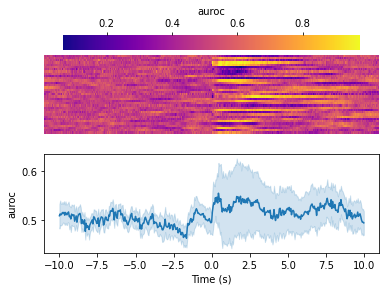

(<Figure size 432x288 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:xlabel='Time (s)', ylabel='auroc'>],
       dtype=object))

In [12]:
combined_data.columns = PE_data.keys()
inx.plot_PE(combined_data, cmap='plasma')

As you can see there is quite some variation, with some cells going down and other going up during the stimulus. There is also something happening before the stimulus onset. Presumably this is because of the presentation of the CS+. Let's have a look at that as well. Note that in this dataset, the onset of the CS+ is signalled by the *offset* of a 1sec pulse on channel GPIO-2. Channel CPIO-2 also has 0.5sec pulses that signal the CS-, so we have to do a little bit more work to grab the timestamps we are interested in.

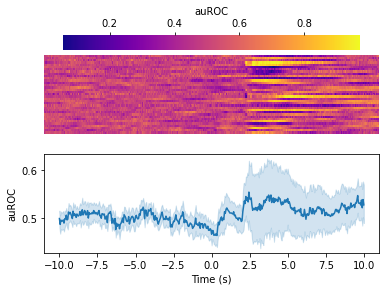

(<Figure size 432x288 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:xlabel='Time (s)', ylabel='auROC'>],
       dtype=object))

In [13]:
# Grab the offset (stop) of stamps with a duration of >0.6sec (e.i. 1 sec) on channel GPIO-2.
timestamps = TTL['GPIO-2'].Stop[TTL['GPIO-2'].Duration>0.6]

# Do the same thing as before to create the peri-event data.
response_to_CS = inx.multi_cell_PE(cells, stamps=timestamps, norm_method='auROC')

# Plot the data
response_to_CS.columns = PE_data.keys()
inx.plot_PE(response_to_CS, cmap='plasma')


The heatmap is not very clear and neither is the averaged data in the bottom panel. This is because some cells go down in response to the stimulus while other cells go up. In that sense it probalby does not make sense to combine all the cells into one figure. The fact that this dataset contains mixed responses to the CS and the stimulus is more obvious if you sort the PE plot by the AUC during the stimulus:

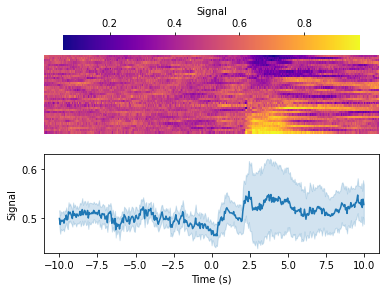

(<Figure size 432x288 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:xlabel='Time (s)', ylabel='Signal'>],
       dtype=object))

In [14]:
# We know that the stimulus is from T=2s to T=4s (because the 2sec CS is from T=0s to T=2s.)
indexer = (response_to_CS.index>=2) & (response_to_CS.index<4)

# Calculate the area under the curve during that interval (by summing).
sorter = response_to_CS[indexer].sum(axis=0)

# Plot, but this time pass a sorter as well
inx.plot_PE(response_to_CS, sorter=sorter, cmap='plasma')

